<a href="https://colab.research.google.com/github/Sushmithaa-Pandian/3D-convolutional-speaker-recognition/blob/master/Wheat_detection_with_YOLO_Sushmithaa_%26_Dharshini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'global-wheat-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F19989%2F1160143%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240414%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240414T150452Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40102bbe822d23572792f557ccd6997913e86ed23d80227e88ec0e7ae919bee1414a9052d647aed4a581c551b846394dadff9f38930ae028948041e0d39d78814b1183c534400d0e4e5c5f2a0336c7159f7f0831fc9b2ab32e9beb1181354f35c76e2184bc51f4b160b2798199134cc377a85fb782ab4810e2cac077c248e61147d7c029becb82d08bc4430bfa47fce41803abb85a03f8c67834b95e3324c24d76a2daf195c11e0bc5d5bfddf8d62b5846a0b37e2fa9a9f197c30a088a99ce25511d97d1bcdf2d95787c2046811e205576e632e7c01b75e2b70c45d25b55805a32b64de86cd79f5de29a3c19d7ba3543e2f5aace2e1b6bd7eefe8b1f0cf09c36'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from enum import Enum
import ast
from tqdm import tqdm
from sklearn import model_selection
import shutil
from glob import glob

In [ ]:
# clone yolov5 github repo
os.system("git clone https://github.com/ultralytics/yolov5.git")

Cloning into 'yolov5'...


0

In [ ]:
# load train.csv
train = pd.read_csv("../input/global-wheat-detection/train.csv")
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [ ]:
# check the size of the dataset
train.shape

(147793, 5)

In [ ]:
# check no. of unique values for width, height,source and image_ids
train.width.nunique(),train.height.nunique(),train.source.nunique(),train.image_id.nunique()

(1, 1, 7, 3373)

- All the images have same width and height i.e. all the images are of shape 1024 by 1024

- We have 147793 no. of rows in the train.csv file

- There are 3373 unique image ids, which means object(wheat) is present more than once in a single image

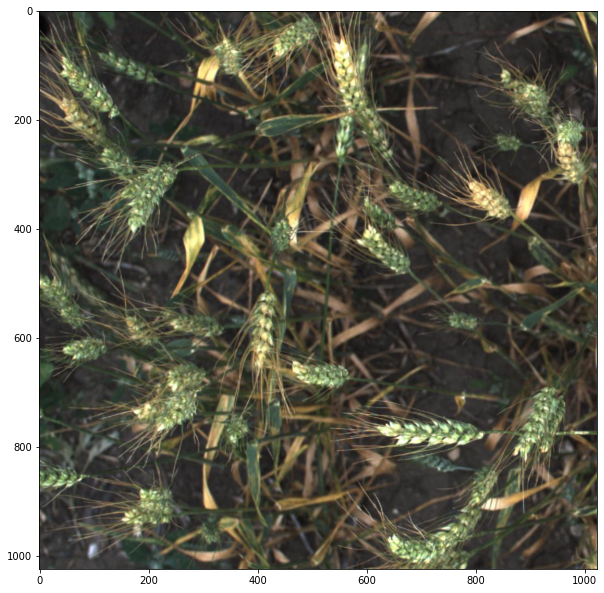

In [ ]:
# plot the first image
import cv2

image = train.loc[0,'image_id']

image = os.path.join("../input/global-wheat-detection/train",image + ".jpg")

plt.figure(figsize=(10,15))
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:
# check the size of the image
from PIL import Image

img=Image.open(image)
w,h=img.size    # w=Width and h=Height
print("Width =",w,end="\t")
print("Height =",h)

Width = 1024	Height = 1024


In [ ]:
# bounding boxes are given as a string, convert them into list
train.bbox = train.bbox.apply(ast.literal_eval)
train.bbox.head()

0     [834.0, 222.0, 56.0, 36.0]
1    [226.0, 548.0, 130.0, 58.0]
2    [377.0, 504.0, 74.0, 160.0]
3    [834.0, 95.0, 109.0, 107.0]
4    [26.0, 144.0, 124.0, 117.0]
Name: bbox, dtype: object

In [ ]:
# group the records by image id, so that we have cordinates of all the objects present in an image
# as list of lists, name the new colum as bboxes
train = train.groupby("image_id")["bbox"].apply(list).reset_index(name="bboxes")

In [ ]:
# check the updated dataset
train.head()

,image_id,bboxes
0,00333207f,"[[0, 654, 37, 111], [0, 817, 135, 98], [0, 192..."
1,005b0d8bb,"[[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15..."
2,006a994f7,"[[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11..."
3,00764ad5d,"[[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1..."
4,00b5fefed,"[[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1..."


In [ ]:
# train test split
df_train,df_valid = model_selection.train_test_split(
    train,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

In [ ]:
# drop the index
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [ ]:
# create folders to meet yolo requirement
os.system(
            f'''
                cd ./yolov5
                mkdir output
                cd output
                mkdir images
                mkdir labels
                cd images
                mkdir train
                mkdir validation
                cd ..
                cd labels
                mkdir train
                mkdir validation
                cd ../
            ''')

0

In [ ]:
# plot the folder structure created above
!tree -d yolov5/output

yolov5/output
├── images
│   ├── train
│   └── validation
└── labels
    ├── train
    └── validation

6 directories


In [ ]:
# Define path
DATA_PATH ="../input/global-wheat-detection/" # this is where training and test images are saved
OUTPUT_PATH = "./yolov5/output/"
IMG_SIZE = 1024
label = 0
EPOCHS = 20
BATCH_SIZE = 8

In [ ]:
# helper function to convert the data into yolo format
# also copy images from train/test folder to yolov5 folder

def process_data(data,data_type=train):
    for _,row in tqdm(data.iterrows()):
        image_name = row.image_id
        bounding_boxes = row.bboxes

        yolo_data = []

        for bbox in bounding_boxes:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]

            x_center = x + w/2
            y_center = y + h/2

            x_center, y_center, w, h = tuple(map(lambda x: x/IMG_SIZE, (x_center, y_center, w, h)))
            yolo_data.append([label,x_center,y_center,w,h])

        yolo_data = np.array(yolo_data)
        np.savetxt(
        os.path.join(OUTPUT_PATH,f"labels/{data_type}/{image_name}.txt"),
            yolo_data,
            fmt=["%d","%f","%f","%f","%f"]
        )

        shutil.copyfile(
        os.path.join(DATA_PATH,f"train/{image_name}.jpg"),
        os.path.join(OUTPUT_PATH,f"images/{data_type}/{image_name}.jpg"),
        )

In [ ]:
# execute above function
process_data(df_train,data_type="train")
process_data(df_valid,data_type="validation")

3035it [00:33, 91.07it/s] 
338it [00:03, 99.93it/s] 


In [ ]:
# verify whether images copied correctly or not
train_images= glob("./yolov5/output/images/train/*.jpg")
validation_images= glob("./yolov5/output/images/validation/*.jpg")
print("no. of training images copied:{},\nno. of test images copied:{}".format(len(train_images),len(validation_images)))

no. of training images copied:3035,
no. of test images copied:338


In [ ]:
# verify whether labels are saved correctly or not
train_labels= glob("./yolov5/output/labels/train/*.txt")
validation_labels= glob("./yolov5/output/labels/validation/*.txt")
print("no. of training labels saved:{},\nno. of test labels copied:{}".format(len(train_labels),len(validation_labels)))

no. of training labels saved:3035,
no. of test labels copied:338


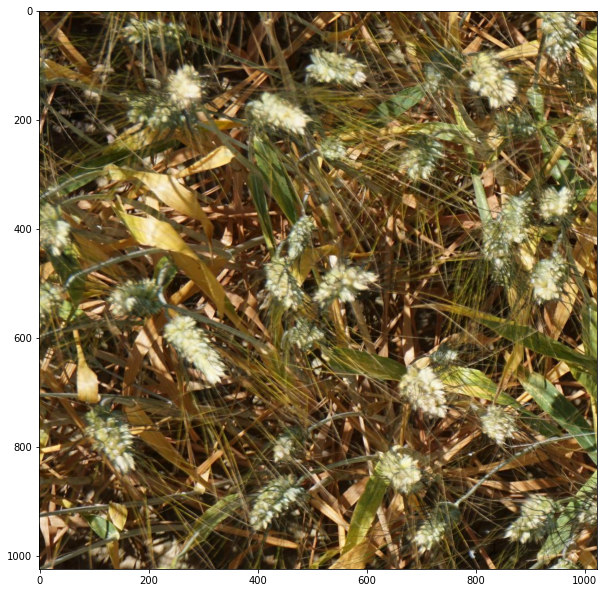

In [ ]:
# check the first image saved in the yolov5 folder
import cv2

image = train_images[0]

plt.figure(figsize=(10,15))
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:

!head -10 "./yolov5/output/labels/train/00333207f.txt"

0 0.018066 0.692871 0.036133 0.108398
0 0.065918 0.845703 0.131836 0.095703
0 0.010742 0.227051 0.021484 0.079102
0 0.034668 0.352539 0.061523 0.037109
0 0.120117 0.365723 0.080078 0.079102
0 0.052734 0.312988 0.046875 0.047852
0 0.206055 0.334961 0.068359 0.052734
0 0.205566 0.147949 0.067383 0.049805
0 0.218750 0.078613 0.041016 0.083008
0 0.046387 0.166992 0.086914 0.056641


- We have correctly saved the labels to the yolov5 folder
- Now we need to create yaml file

In [ ]:


OUTPUT_PATH = "./output"
with open(f"./yolov5/ws_data.yaml", "w+") as file_:
        file_.write(
            f"""

            train: {OUTPUT_PATH}/images/train
            val: {OUTPUT_PATH}/images/validation
            nc: 1
            names: ["wheat"]

            """
        )

In [ ]:
# yaml file
!cat "./yolov5/ws_data.yaml"


            
            train: ./output/images/train
            val: ./output/images/validation
            nc: 1
            names: ["wheat"]
            
            

In [ ]:
# helper function to train the yolo v5 model
def trainYoloModel(model_name: str,preTrainedWeights_path = None):
    """
    Helper function to train YOLO v5 models

    """
    mapper = {}
    for idx, model_ in enumerate(glob("yolov5/models/*yaml")):
        mapper[idx + 1] = model_
        print(f"{idx + 1} =>  {model_.split('/')[-1].split('.')[0]}")

    model = mapper[2]

    if preTrainedWeights_path is not None:
        os.system(
            f"""
                python yolov5/train.py --img {IMG_SIZE} --batch {BATCH_SIZE} --epochs {EPOCHS} --data yolov5/ws_data.yaml --cfg {model} --name {model_name} --weights {preTrainedweights_path}

            """
        )
    else:
        os.system(
            f"""
                python yolov5/train.py --img {IMG_SIZE} --batch {BATCH_SIZE} --epochs {EPOCHS} --data yolov5/ws_data.yaml --cfg {model} --name {model_name}
            """
        )

In [ ]:
trainYoloModel(model_name = "ws_yolov5",preTrainedWeights_path = None)

1 =>  yolov5m
2 =>  yolov5n
3 =>  yolov5x
4 =>  yolov5l
5 =>  yolov5s
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5n.yaml, data=yolov5/ws_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=8, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=ws_yolov5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: Ultralytics requ

In [ ]:
!tree -f yolov5/runs

In [ ]:
# helper function to make predictions
def predict(images_path:"path to the test images", weights_path: "path to the weights folder"):
    """
    Helper function to make predictions over images using Yolo
    """
    os.system(
        f"""
            python yolov5/detect.py --source {images_path} --weights {weights_path}
        """)

predict(images_path = "../input/global-wheat-detection/test",
       weights_path = "yolov5/runs/train/ws_yolov5/weights/best.pt")

In [ ]:

!tree -f yolov5/runs/detect/exp

In [ ]:
# plot images with objects detected
from skimage import io
import plotly.express as px
import plotly.graph_objs as go

def showImages(image_dir: "path to image directory"):
    """
    Helper function to visualize images in a directory

    """
    imgs_paths = glob(image_dir + "/*jpg")
    numImgs = len(imgs_paths)

    for i in range(numImgs):
        img = io.imread(imgs_paths[i])
        fig = px.imshow(img)
        fig.show()


showImages(image_dir = "yolov5/runs/detect/exp")